In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re 
import string 
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer

In [70]:

from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

In [71]:
df = pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [72]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [73]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [74]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [75]:
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})

In [76]:
text_df.Review.isna().sum()

3811

In [77]:
text_df.head()

,Recommended,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [78]:

print("My data's shape is:", text_df.shape)
text_df.head()


My data's shape is: (23486, 2)


,Recommended,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [79]:
print("Before dropping text_df: ",text_df.shape)
text_df.drop_duplicates(inplace = True)
print("After dropping text_df: ",text_df.shape)

Before dropping text_df:  (23486, 2)
After dropping text_df:  (19673, 2)


In [80]:
text_df.head()

,Recommended,Review
0,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...


In [81]:
text_df.isnull().sum(axis=0).sort_values()

Recommended    0
Review         2
dtype: int64

In [82]:
text_df.dropna(inplace=True)
text_df.head()
print("After dropping NaN text_df: ",text_df.shape)

After dropping NaN text_df:  (19671, 2)


In [83]:
text_df['Recommended'].value_counts()

1    16096
0     3575
Name: Recommended, dtype: int64

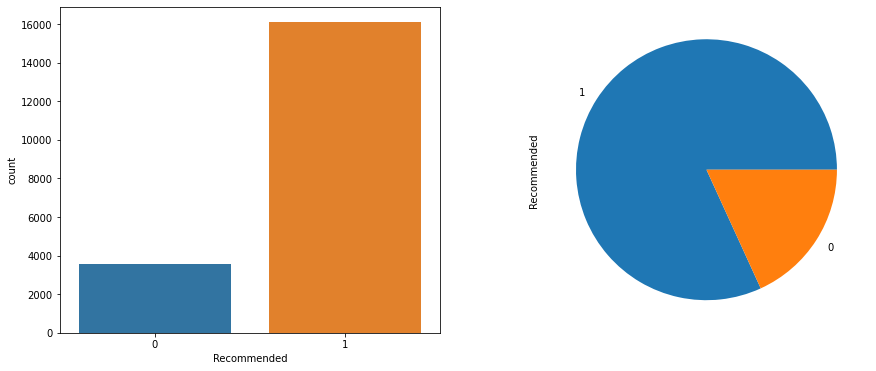

In [84]:
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=text_df['Recommended'])
plt.subplot(1, 2, 2)
text_df['Recommended'].value_counts().plot.pie(y='Class')

# Upsampling

In [85]:
from sklearn.utils import resample


df_majority = text_df[(text_df['Recommended']==1)] 
df_minority = text_df[(text_df['Recommended']==0)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=15539 , # to match majority class
                                 random_state=42)  # reproducible results
                                 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

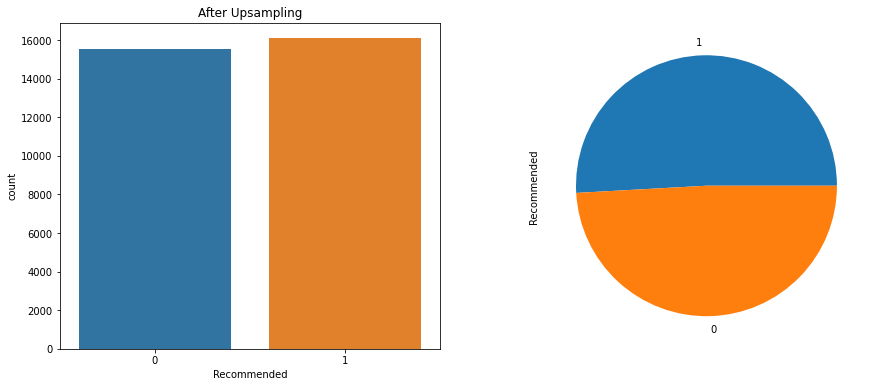

In [86]:
plt.figure(figsize = (15, 6))
ax=plt.subplot(1, 2, 1)
sns.countplot(x=df_upsampled['Recommended'])
ax.set_title('After Upsampling')
plt.subplot(1, 2, 2)
df_upsampled['Recommended'].value_counts().plot.pie(y='Class')

# Data Preprocessing

In [87]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [88]:
df_upsampled["Cleaned_Review"] = np.vectorize(remove_pattern)(df_upsampled["Review"], "@[\w]*")

In [89]:
#  Remove all the present special characters, numbers and punctuations
df_upsampled["Cleaned_Review"] = df_upsampled["Cleaned_Review"].str.replace("[^a-zA-Z#]", " ")
df_upsampled.head()

,Recommended,Review,Cleaned_Review
20700,0,Very large; lace is kinda coarse Thought i'd l...,Very large lace is kinda coarse Thought i d l...
23020,0,Way too much fabric I wanted to love this jump...,Way too much fabric I wanted to love this jump...
5625,0,So surprised by the poor quality I loved the l...,So surprised by the poor quality I loved the l...
8695,0,"Runs large I so wanted to love this tank, and ...",Runs large I so wanted to love this tank and ...
7689,0,"If you have a chest, beware I got this top in ...",If you have a chest beware I got this top in ...


In [90]:
#Removing short words (words with length less than 3)
df_upsampled["Cleaned_Review"] = df_upsampled["Cleaned_Review"].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df_upsampled.head()

,Recommended,Review,Cleaned_Review
20700,0,Very large; lace is kinda coarse Thought i'd l...,Very large lace kinda coarse Thought love this...
23020,0,Way too much fabric I wanted to love this jump...,much fabric wanted love this jumpsuit looks ad...
5625,0,So surprised by the poor quality I loved the l...,surprised poor quality loved look this sweater...
8695,0,"Runs large I so wanted to love this tank, and ...",Runs large wanted love this tank excited mail ...
7689,0,"If you have a chest, beware I got this top in ...",have chest beware this typical size medium wan...


# Tokenization

In [91]:
tokenized_tweet = df_upsampled["Cleaned_Review"].apply(lambda x: x.split())
tokenized_tweet.head()

20700    [Very, large, lace, kinda, coarse, Thought, lo...
23020    [much, fabric, wanted, love, this, jumpsuit, l...
5625     [surprised, poor, quality, loved, look, this, ...
8695     [Runs, large, wanted, love, this, tank, excite...
7689     [have, chest, beware, this, typical, size, med...
Name: Cleaned_Review, dtype: object

# Data Visualization

In [92]:
df["Rating"].value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64

As shown in the above graph, Although more than 50% of customers rated "5" for the store's products, about more than 11% of customers were not satisfies by the products and voted for "1" and "2".

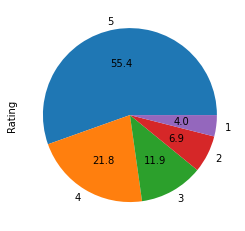

In [93]:
round(df['Rating'].value_counts()/df.shape[0]*100).plot.pie(autopct='%1.1f') 

In [94]:
df["Department Name"].value_counts()

Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: Department Name, dtype: int64

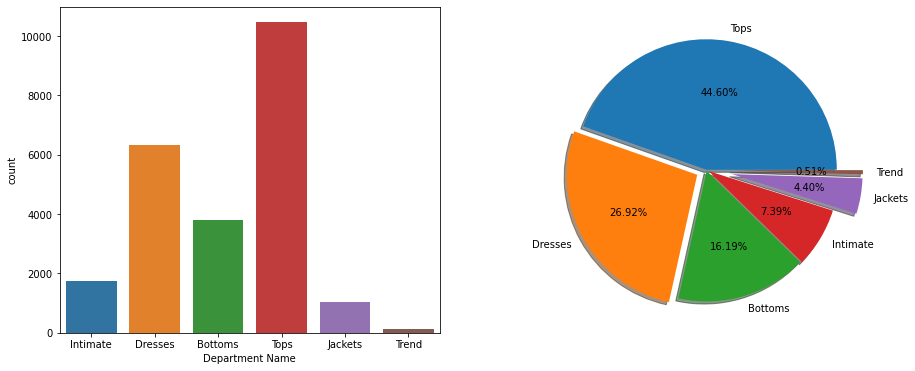

In [95]:
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = df['Department Name'], data = df)

plt.subplot(1, 2, 2)
plt.pie(x= df['Department Name'].value_counts(),labels=('Tops','Dresses',"Bottoms","Intimate","Jackets","Trend") ,explode = (0, 0.08, 0.01,0.02,0.2,0.2), shadow = True, autopct = '%1.2f%%')

plt.show()

Text(0.5, 1.0, 'Age Distribution')

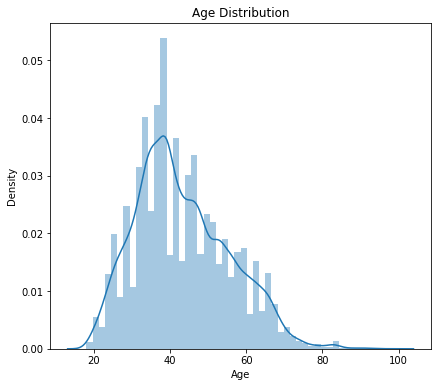

In [96]:
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
plt.title = ('Age_distribution')
sns.distplot(df['Age']).set_title("Age Distribution")

The majority of customers age between 30 and 50 yeare old.

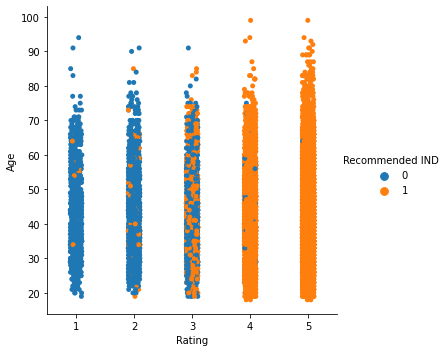

In [97]:
sns.catplot(x="Rating", y="Age", hue="Recommended IND",data= df)

From this we can observe that review Ratings of 1 and 2 are not Recomended whereas 4 and 5 are recommended.

In [98]:
import plotly.express as px
FreqOfWords = df['Review Text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [99]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words=stopwords.words("english")
new_stopping_words = stop_words[:len(stop_words)-36]
new_stopping_words.remove("not")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
def remove_punc(df):
    new_text= re.sub("n't",'not', df)
    new_text= re.sub('[^\w\s]','', df)
    return new_text

In [101]:
# processed_text=remove_punc(str(df["Review Text"]))
# processed_text
processed_text=remove_punc(str(df_upsampled["Cleaned_Review"]))
processed_text


'20700    Very large lace kinda coarse Thought love this\n23020    much fabric wanted love this jumpsuit looks ad\n5625     surprised poor quality loved look this sweater\n8695     Runs large wanted love this tank excited mail \n7689     have chest beware this typical size medium wan\n                                                       \n23479    What piece wasn sure about ordering this skirt\n23481    Great dress many occasions very happy snag thi\n23482    Wish made cotton reminds maternity clothes sof\n23484    Very cute dress perfect summer parties bought \n23485    Please make more like this This dress lovely p\nName Cleaned_Review Length 31635 dtype object'

In [102]:
def tokenizze(df):
    newdata= word_tokenize(df)
    return newdata

In [103]:
tokenized_data=tokenizze(processed_text.lower())
tokenized_data

['20700',
 'very',
 'large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'this',
 '23020',
 'much',
 'fabric',
 'wanted',
 'love',
 'this',
 'jumpsuit',
 'looks',
 'ad',
 '5625',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'this',
 'sweater',
 '8695',
 'runs',
 'large',
 'wanted',
 'love',
 'this',
 'tank',
 'excited',
 'mail',
 '7689',
 'have',
 'chest',
 'beware',
 'this',
 'typical',
 'size',
 'medium',
 'wan',
 '23479',
 'what',
 'piece',
 'wasn',
 'sure',
 'about',
 'ordering',
 'this',
 'skirt',
 '23481',
 'great',
 'dress',
 'many',
 'occasions',
 'very',
 'happy',
 'snag',
 'thi',
 '23482',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'sof',
 '23484',
 'very',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 '23485',
 'please',
 'make',
 'more',
 'like',
 'this',
 'this',
 'dress',
 'lovely',
 'p',
 'name',
 'cleaned_review',
 'length',
 '31635',
 'dtype',
 'object']

In [104]:
def remove_num(df):
    text_without_num=[w for w in df if w.isalpha()]
    return text_without_num

In [105]:
textwithoutnum= remove_num(tokenized_data)
textwithoutnum

['very',
 'large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'this',
 'much',
 'fabric',
 'wanted',
 'love',
 'this',
 'jumpsuit',
 'looks',
 'ad',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'this',
 'sweater',
 'runs',
 'large',
 'wanted',
 'love',
 'this',
 'tank',
 'excited',
 'mail',
 'have',
 'chest',
 'beware',
 'this',
 'typical',
 'size',
 'medium',
 'wan',
 'what',
 'piece',
 'wasn',
 'sure',
 'about',
 'ordering',
 'this',
 'skirt',
 'great',
 'dress',
 'many',
 'occasions',
 'very',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'sof',
 'very',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 'please',
 'make',
 'more',
 'like',
 'this',
 'this',
 'dress',
 'lovely',
 'p',
 'name',
 'length',
 'dtype',
 'object']

In [106]:
def remove_stops(df):
    
    newdata=[t for t in df if t not in new_stopping_words]
    return newdata

In [107]:
data=remove_stops(textwithoutnum)
data

['large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'much',
 'fabric',
 'wanted',
 'love',
 'jumpsuit',
 'looks',
 'ad',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'sweater',
 'runs',
 'large',
 'wanted',
 'love',
 'tank',
 'excited',
 'mail',
 'chest',
 'beware',
 'typical',
 'size',
 'medium',
 'wan',
 'piece',
 'wasn',
 'sure',
 'ordering',
 'skirt',
 'great',
 'dress',
 'many',
 'occasions',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'sof',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 'please',
 'make',
 'like',
 'dress',
 'lovely',
 'p',
 'name',
 'length',
 'dtype',
 'object']

In [108]:
def lemmatizze(df):
    newdata= [WordNetLemmatizer().lemmatize(t) for t in df]
    return newdata

In [109]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [110]:
final_data=lemmatizze(data)
final_data

['large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'much',
 'fabric',
 'wanted',
 'love',
 'jumpsuit',
 'look',
 'ad',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'sweater',
 'run',
 'large',
 'wanted',
 'love',
 'tank',
 'excited',
 'mail',
 'chest',
 'beware',
 'typical',
 'size',
 'medium',
 'wan',
 'piece',
 'wasn',
 'sure',
 'ordering',
 'skirt',
 'great',
 'dress',
 'many',
 'occasion',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'sof',
 'cute',
 'dress',
 'perfect',
 'summer',
 'party',
 'bought',
 'please',
 'make',
 'like',
 'dress',
 'lovely',
 'p',
 'name',
 'length',
 'dtype',
 'object']

In [111]:
joined_data=" ".join(final_data)

In [112]:
joined_data

'large lace kinda coarse thought love much fabric wanted love jumpsuit look ad surprised poor quality loved look sweater run large wanted love tank excited mail chest beware typical size medium wan piece wasn sure ordering skirt great dress many occasion happy snag thi wish made cotton reminds maternity clothes sof cute dress perfect summer party bought please make like dress lovely p name length dtype object'

In [113]:
def Cleaning_process(df):
    processed_text=remove_punc(str(df))
    tokenized_data=tokenizze(processed_text.lower())
    textwithoutnum= remove_num(tokenized_data)
    data=remove_stops(textwithoutnum)
    final_data=lemmatizze(data)
    return " ".join(final_data)

    

In [114]:
text = Cleaning_process(str(df_upsampled["Cleaned_Review"]))
text

'large lace kinda coarse thought love much fabric wanted love jumpsuit look ad surprised poor quality loved look sweater run large wanted love tank excited mail chest beware typical size medium wan piece wasn sure ordering skirt great dress many occasion happy snag thi wish made cotton reminds maternity clothes sof cute dress perfect summer party bought please make like dress lovely p name length dtype object'

In [115]:
df_upsampled["Cleaned_Review"]= df_upsampled["Cleaned_Review"].apply(Cleaning_process)

In [116]:
df_upsampled.head()

,Recommended,Review,Cleaned_Review
20700,0,Very large; lace is kinda coarse Thought i'd l...,large lace kinda coarse thought love sucker la...
23020,0,Way too much fabric I wanted to love this jump...,much fabric wanted love jumpsuit look adorable...
5625,0,So surprised by the poor quality I loved the l...,surprised poor quality loved look sweater work...
8695,0,"Runs large I so wanted to love this tank, and ...",run large wanted love tank excited mail size s...
7689,0,"If you have a chest, beware I got this top in ...",chest beware typical size medium wanted love g...


In [117]:
FreqOfWords = df_upsampled["Cleaned_Review"].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

# Word Cloud 

In [118]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


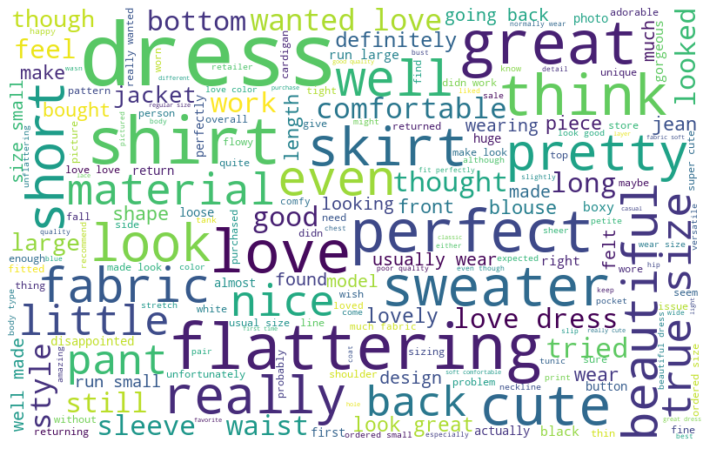

In [119]:
#Visualizing the Keywords
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

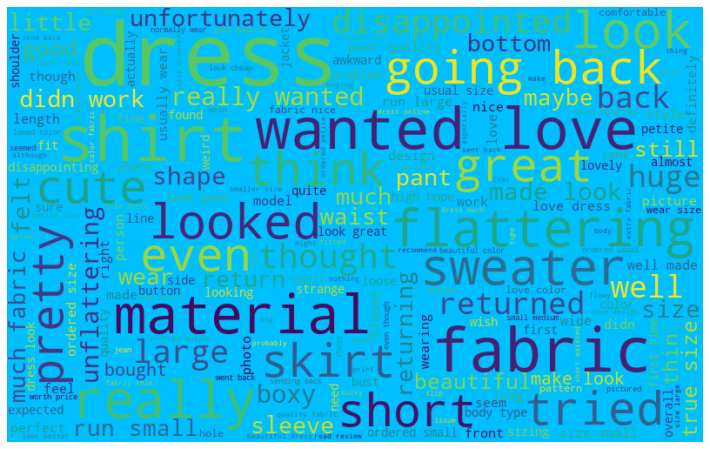

In [120]:
#Frequent words visualization for negative label
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"][df_upsampled["Recommended"]==0]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='deepskyblue', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")

plt.axis("off")
plt.show()

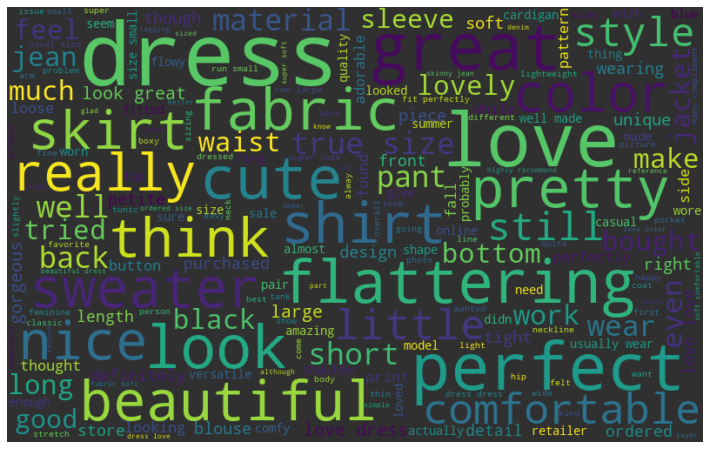

In [121]:
#Frequent words visualization for Positive Review
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"][df_upsampled["Recommended"]==1]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color = '#303030', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [122]:

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF are word frequency scores that try to highlight words that are more interesting,

In [123]:
x = df_upsampled["Cleaned_Review"]
y= df_upsampled["Recommended"]

In [124]:
#tokenization

from keras.preprocessing.text import Tokenizer
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x)
xtokens= tokenizer.texts_to_sequences(x)

In [125]:

from keras_preprocessing.sequence import pad_sequences

maxlen=50
xpad=pad_sequences(xtokens,padding='post', maxlen=maxlen)

In [126]:
#train_test splot
x_train, x_test, y_train, y_test = train_test_split(xpad, y, test_size=0.2, stratify=y,random_state=42)

In [127]:
accuracy_list = []
f1_list = []
roc_auc_list = []

In [128]:
def result(model):
    
    #fit on data
    model.fit(x_train, y_train)
    
    #prediction
    pred = model.predict(x_test)
    
    #performance of model
    print("Classification Report: \n", classification_report(y_test, pred))
    print("-" * 100)
    print()
    
    #accuracy of model
    acc = accuracy_score(y_test, pred)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()
    
    #f1-score of model
    f1 = f1_score(y_test, pred)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()

    #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(y_test,pred)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(y_test, pred)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()
    
    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');


In [129]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout,GRU,Bidirectional
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2


model=Sequential()

model.add(Embedding(input_dim=num_words,output_dim=32,input_length=maxlen))

model.add(LSTM(units=64,dropout=0.4,return_sequences=True))
model.add(LSTM(units=64,dropout=0.4,return_sequences=True))
  
Dense(16, activation='relu')

model.add(LSTM(units=20))
model.add(Dropout(0.5))


model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            320000    
                                                                 
 lstm_3 (LSTM)               (None, 50, 64)            24832     
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 20)                6800      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 384,677
Trainable params: 384,677
Non-tr

In [130]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="auto", 
                           verbose=1, patience = 10, restore_best_weights=True)

In [131]:
model.fit(x_train,y_train, epochs=20, batch_size=32, validation_data=(x_test , y_test), callbacks= [early_stop])

Epoch 1/20
791/791 [==============================] - 21s 21ms/step - loss: 0.6073 - accuracy: 0.6611 - val_loss: 0.5186 - val_accuracy: 0.7738
Epoch 2/20
791/791 [==============================] - 16s 21ms/step - loss: 0.4308 - accuracy: 0.8178 - val_loss: 0.2855 - val_accuracy: 0.8928
Epoch 3/20
791/791 [==============================] - 11s 14ms/step - loss: 0.2815 - accuracy: 0.9019 - val_loss: 0.2396 - val_accuracy: 0.9156
Epoch 4/20
791/791 [==============================] - 10s 13ms/step - loss: 0.2210 - accuracy: 0.9269 - val_loss: 0.2218 - val_accuracy: 0.9213
Epoch 5/20
791/791 [==============================] - 10s 13ms/step - loss: 0.1925 - accuracy: 0.9398 - val_loss: 0.2101 - val_accuracy: 0.9314
Epoch 6/20
791/791 [==============================] - 10s 12ms/step - loss: 0.1700 - accuracy: 0.9472 - val_loss: 0.2150 - val_accuracy: 0.9341
Epoch 7/20
791/791 [==============================] - 10s 12ms/step - loss: 0.1507 - accuracy: 0.9546 - val_loss: 0.2009 - val_accuracy:

In [132]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
cr = classification_report(y_test,predictions)
print(cr)

198/198 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      3108
           1       0.98      0.88      0.92      3219

    accuracy                           0.93      6327
   macro avg       0.93      0.93      0.93      6327
weighted avg       0.93      0.93      0.93      6327



In [133]:
#performance of model
print("Classification Report: \n", classification_report(y_test, predictions))
print("-" * 100)
print()

#accuracy of model
acc = accuracy_score(y_test, predictions)
accuracy_list.append(acc)
print("Accuracy Score: ", acc)
print("-" * 100)
print()

#f1-score of model
f1 = f1_score(y_test, predictions)
f1_list.append(f1)
print("F1 Score: ", f1)
print("-" * 100)
print()

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      3108
           1       0.98      0.88      0.92      3219

    accuracy                           0.93      6327
   macro avg       0.93      0.93      0.93      6327
weighted avg       0.93      0.93      0.93      6327

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9253990832938201
----------------------------------------------------------------------------------------------------

F1 Score:  0.9226989846053062
----------------------------------------------------------------------------------------------------

